# comparaison beetween ship/hipp and friedrichknuth/hipp

This notebook used to illustrate the difference beetween shipp/hipp and friedrichknuth/hipp
Note: shipp/hipp is almost a copy of friedrichknuth/hipp with some small differences

To illustrate the difference let's use the same dataset shown in the [image restitution notebook](https://github.com/friedrichknuth/hipp/blob/master/examples/image_restitution/notebook.ipynb). This dataset is composed of 41 images of the South Cascade Glacier in 09/06/1994

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import hipp
import os

## Downloading the dataset

The dataset consists of 41 images of the South Cascade Glacier acquired on September 6, 1994.
The total download size is approximately 17 GB, but after GDAL optimization, the entire dataset occupies only around 9 GB on disk.

In [3]:
metadata_directory = "1994_06_09_aerial_scg.csv"
images_directory = "preprocessing/raw_images"

if not os.path.exists(images_directory):
    hipp.dataquery.NAGAP_download_images_to_disk(metadata_directory, images_directory)

Optimizing: 100%|██████████| 41/41 [00:49<00:00,  1.21s/file]


The first difference is the usage of a class. The `hipp.AerialPreprocessing` class is used here to simplify the path management to manage quality control and to allow multi-thread. But all of the logic are in hipp/aerial/core.py.

So let create an instance of this class with all path we want:
- `images_directory`: The directory who contain our 41 tif images
- `fiducials_directory`: The directory of fiducials templates we will create (or existing)
- `preprocess_images`: The output directory to put preprocessed images
- `qc_directory`: The directory to store all quality control stuffs

In [4]:
preproc = hipp.AerialPreprocessing(images_directory)

## Creation of fiducials templates

Fiducial templates are created using a single method, `create_fiducial_template`, which can be called with either "corner" or "midside" to generate the corresponding template. This method allows you to click on the full-resolution image to select the fiducial. It then enhances the image resolution and lets you click precisely on the center of the fiducial to achieve subpixel accuracy.

The equivalent functions in `friedrichknuth/hipp` are:
```python
hipp.core.create_fiducial_template
hipp.utils.enhance_geotif_resolution
hipp.core.create_fiducial_template
```
Another key difference is in the point selection interface: this version uses OpenCV (cv2) instead of Panel. While the OpenCV-based approach is less powerful—since it loads the full image rather than streaming image tiles based on zoom level—it is lighter and faster for standard-size images. Panel, although more advanced, is significantly heavier in terms of dependencies and runtime performance.

In [5]:
coords_corner = {'fiducial_coordinate': (1115, 381), 'subpixel_center_coordinate': (805, 803)}

_ = preproc.create_fiducial_template(corner=True, **coords_corner)

In [6]:
coords_midside = {'fiducial_coordinate': (1040, 5881), 'subpixel_center_coordinate': (803, 803)}

_ = preproc.create_fiducial_template(midside=True, **coords_midside)

## Detection of fiducials on images

The first difference is the way of use subblock of the image. The image is divided in n*n blocks where n is the parameters `grid_size` of the detect_fiducials method (`grid_size` must be an odd number). It's important that the corner image block fit the corner fiducial and the midside block fit the midside fiducial. It improve the speed of the detection and the ram consuption because we don't load the full image.

This method use of multi-thread to increase the speed of the detection.

In terms of time it detect all fiducials of the 41 images (midside and corners) in 20 seconds for 4min30 for `friedrichknuth/hipp`.

The computation of the principal point is slightly different cause we compute pp with all fiducials even if some fiducials are miss detected.
So some principal points are false and we can see this in the principal points deviation plot.




Fiducials detection:   0%|          | 0/41 [00:00<?, ?it/s]/home/godinlu/.local/share/hatch/env/virtual/hipp/6cXfZaze/dev/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Fiducials detection: 100%|██████████| 41/41 [00:15<00:00,  2.62it/s]


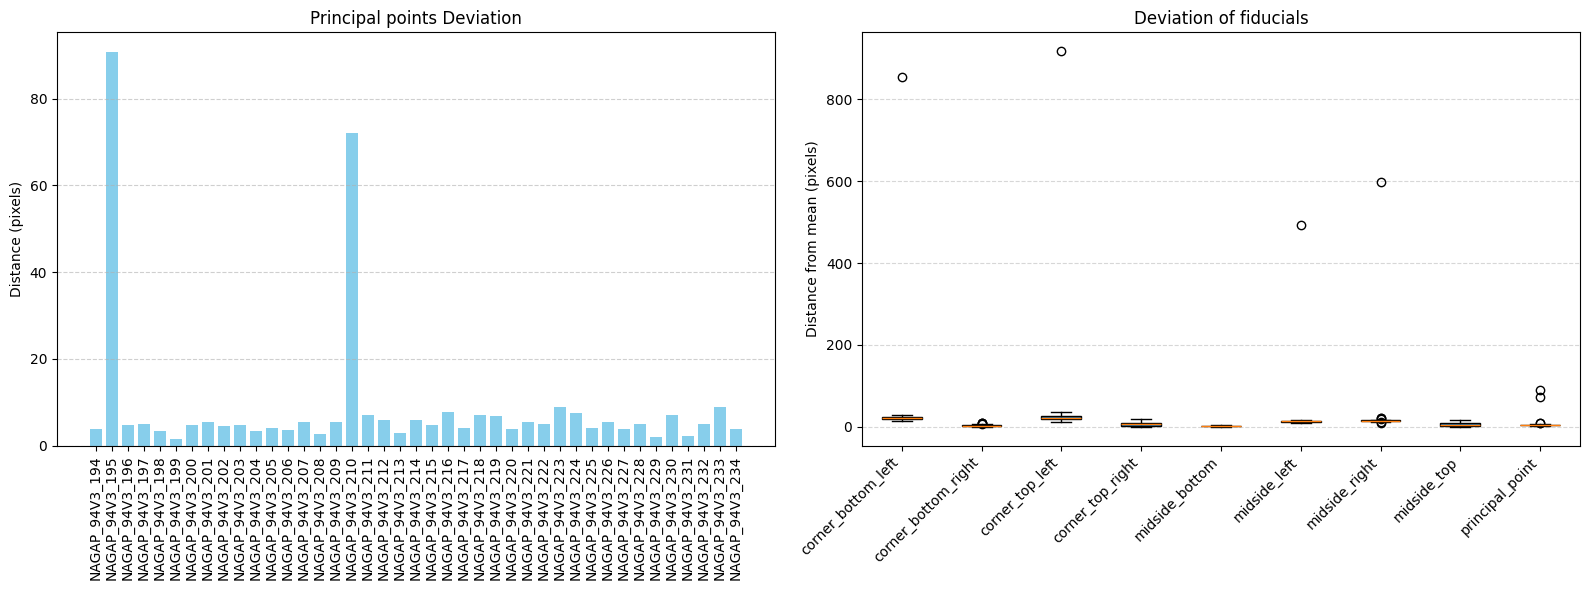

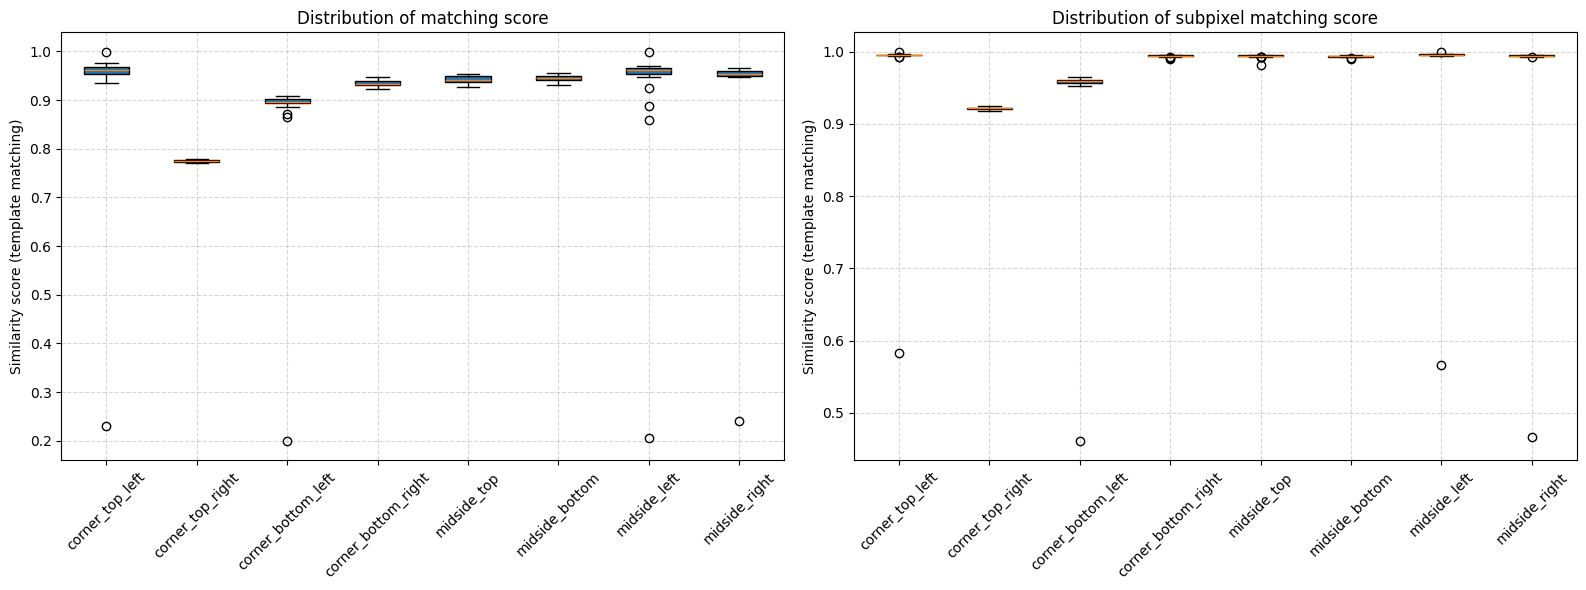

In [7]:
all_detections, all_scores, all_subpixel_scores = preproc.detect_fiducials(grid_size=7)

## 3. Outlier Removal  

Filters out false positives based on two criteria:

- **Geometric Consistency:** Calculates angles between fiducials, validating those close to 90°, assuming a square fiducial pattern.
- **Matching Score Thresholding:** Compares the score of each match to the median score and keeps only those above a certain threshold (similar to [`eval_matches`](https://github.com/friedrichknuth/hipp/blob/master/hipp/core/core.py#L603)).

After filtering:
- The principal point is recalculated using valid diagonal and adjacent fiducials.
- For adjacent fiducials: the midpoint of the segment is computed, and a perpendicular offset is applied based on half the segment length.
- For diagonal fiducials: the midpoint of the segment is used directly.


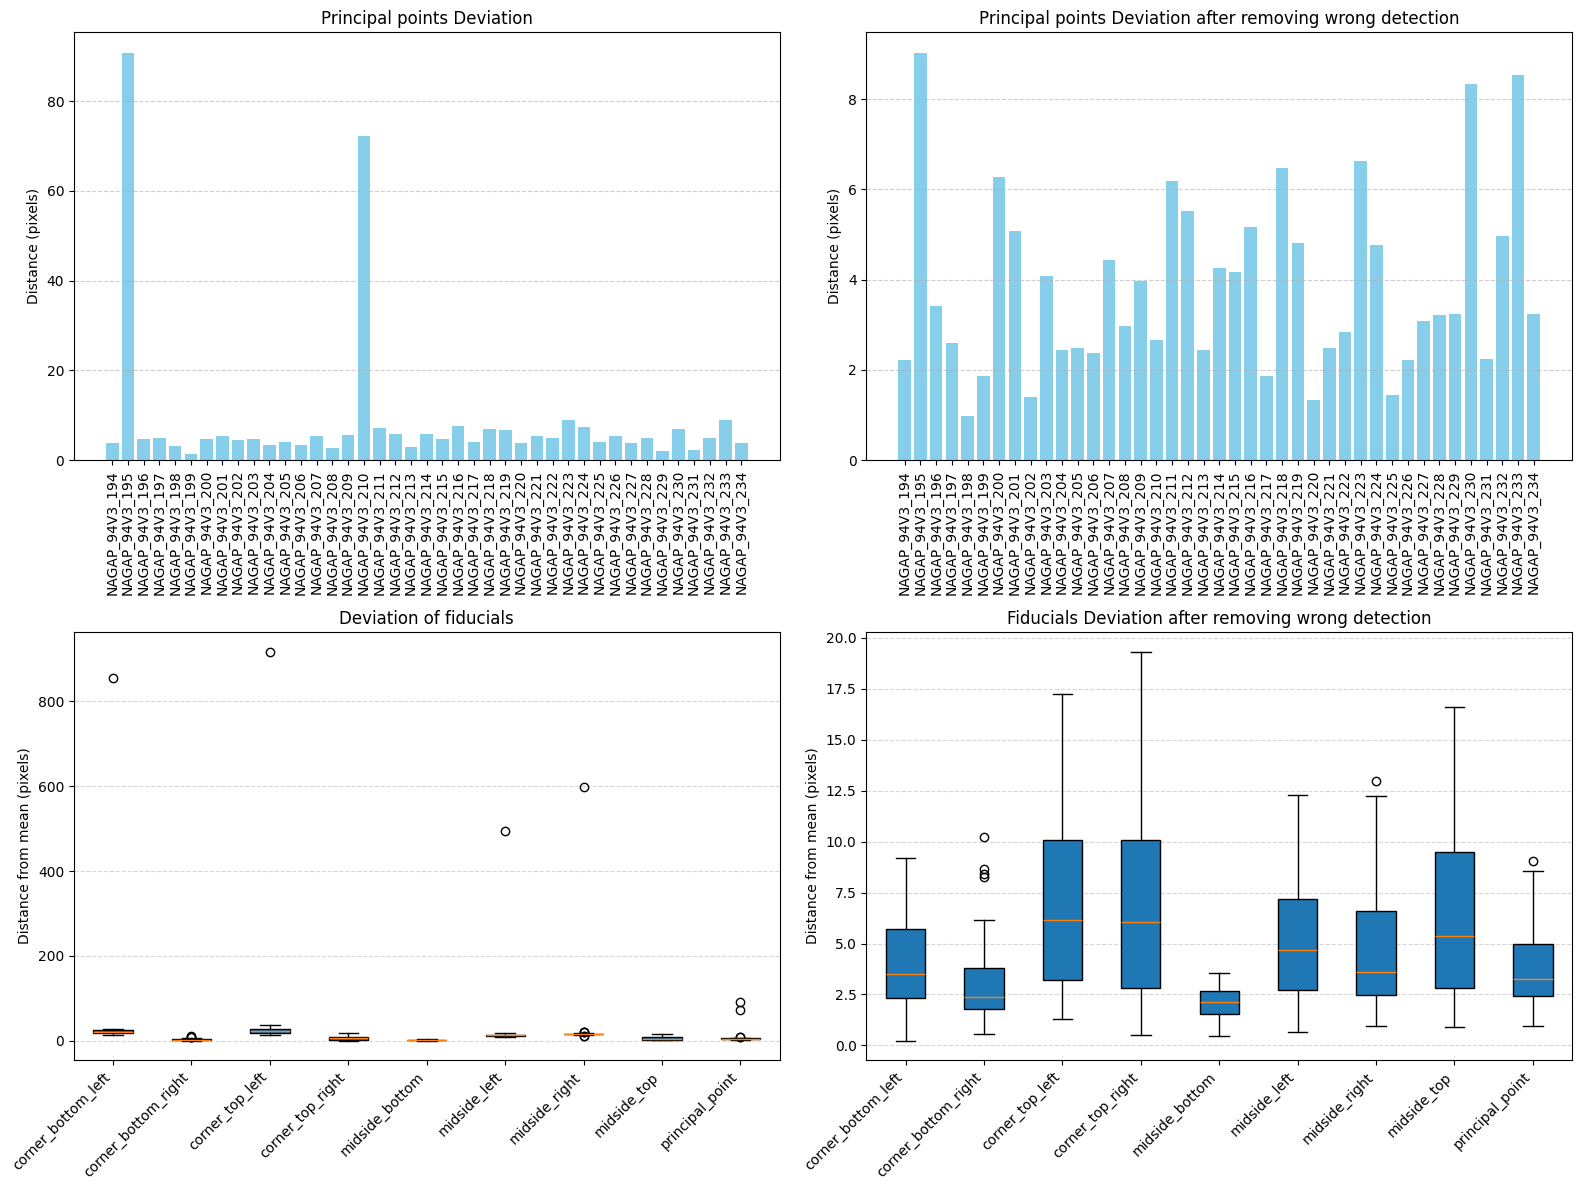

In [8]:
filtered_detections = preproc.filter_detected_fiducials(all_detections, all_scores, all_subpixel_scores, degree_threshold=0.005)

# we can save the detections in a csv file if we want
hipp.aerial.detected_fiducials_to_csv(filtered_detections, "preprocessing/detected_fiducial_markers.csv")

## Image restitution

The goal of this step is to correct some small distortion in the image. To achieve this, the objective is to align the detected fiducials with true fiducials founded in [calibration report](./Report_OSL_1785.pdf). 
1. **Convert true fiducials** : Convert the `true_fiducials_mm` in the image reference system. To do this we divided all coordinate by the `scanning_resolution_mm` and translate coordinate with each principal point.
2. **Estimate the transformation** : Chooses the appropriate geometric transformation to aligne true fiducials with detected fiducials based on the number of valid fiducial points:
    - 1 point: Translation
    - 2 points: Similarity transformation
    - 3 or more points: Affine transformation
3. **Transform the image**: Transform the image using the transformation matrix computed previously.
4. **Crop image**: Crop the previously transformed image around the transformated principal point.

In [9]:
true_fiducials_mm = {
    "corner_bottom_left": (-109.990, -110.002), # 1
    "corner_top_right": (110.010, 109.999), # 2
    "corner_top_left": (-109.989, 109.9995), # 3
    "corner_bottom_right": (109.998, -110.002), # 4
    "midside_left": (-111.998, -0.004), # 5
    "midside_right": (112.004, 0.000), # 6
    "midside_top": (-0.014, 111.993), # 7
    "midside_bottom": (0.000, -112.002) # 8
}

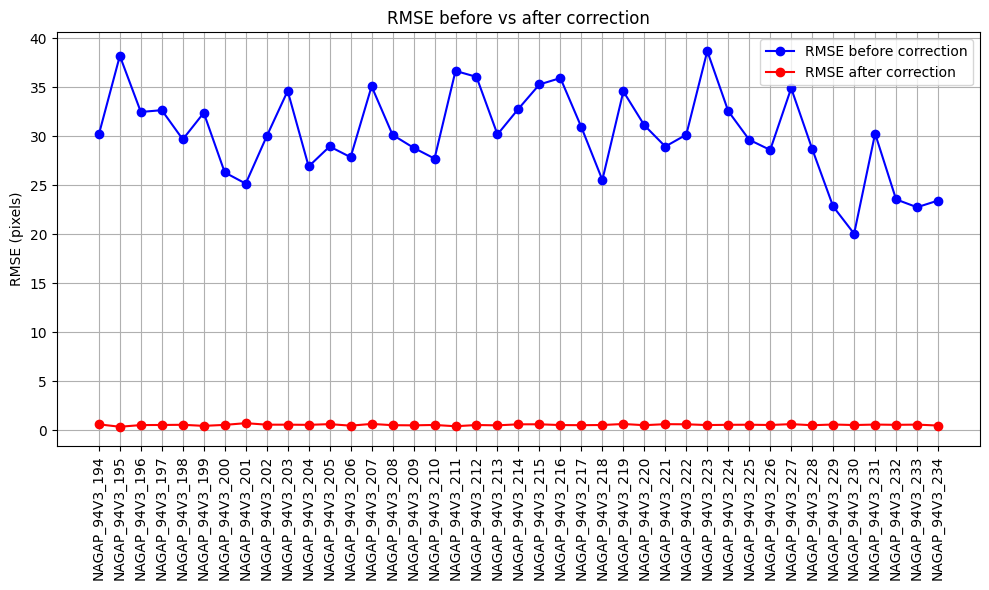

In [10]:
transformation_matrixs = preproc.images_restitution(
    filtered_detections,
    true_fiducials_mm,
    image_square_dim=11200, # this parameters can be calculated, if i want a 224 mm images then i convert in pixels with 224 / scanning_resolution_mm
    scanning_resolution_mm=0.02,
    max_workers=8,
    dry_run=True # set this option to False to transform images 
)

The `AerialPreprocessing.images_restitution` method returns a dictionary of transformation matrices that can be used to map the previously detected fiducial markers onto the preprocessed images. This allows the fiducial coordinates to be correctly expressed in the coordinate system of the transformed images.

> ⚠️ **Note:** If the cropping applied during preprocessing is too aggressive, some fiducial markers may fall outside the bounds of the resulting image.


In [11]:
transformed_detections = {k: v.transform(transformation_matrixs[k]) for k, v in filtered_detections.items()}

# we can save the transformed detections in a csv file if we want
hipp.aerial.detected_fiducials_to_csv(transformed_detections, "preprocessing/detected_fiducial_markers_transformed.csv")